In [49]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from kerastuner.tuners import RandomSearch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
df = pd.read_csv('Updated_FinalFilteredCombined.csv')

# Display the first 5 rows
print(df.head())

# Print the column names and their data types
print(df.info())

   index  AADT_VN  BEGIN_POIN  COUNTY_COD  END_POINT  IRI_VN  IS_IMPROVED  \
0      0    44290         5.3          97        5.4      44            0   
1      1    44750         5.3          97        5.4      48            0   
2      2    45760         5.3          97        5.4      80            0   
3      3    48670         5.3          97        5.4      43            1   
4      4    49080         5.3          97        5.4      39            1   

       ROUTE_ID  SPEED_LIMI  THROUGH_LA  YEAR_RECOR  curval  \
0  IN0000100000        60.0           4        2013     263   
1  IN0000100000        60.0           4        2014     268   
2  IN0000100000        60.0           4        2015     192   
3  IN0000100000        70.0           4        2016     176   
4  IN0000100000        70.0           4        2017     205   

                                      geometry_paths  tmiles  tons  value  
0  [[[-88.31770505199995, 30.49976574300007], [-8...      15   716    270  
1  [[[

In [50]:
print(df.columns)

Index(['index', 'AADT_VN', 'BEGIN_POIN', 'COUNTY_COD', 'END_POINT', 'IRI_VN',
       'IS_IMPROVED', 'ROUTE_ID', 'SPEED_LIMI', 'THROUGH_LA', 'YEAR_RECOR',
       'curval', 'geometry_paths', 'tmiles', 'tons', 'value'],
      dtype='object')


In [51]:
df['index'] = df['index'] + 1

In [52]:
train_months = df['index']

In [53]:
cols = ['AADT_VN', 'BEGIN_POIN', 'COUNTY_COD', 'END_POINT', 'IS_IMPROVED', 'SPEED_LIMI', 'THROUGH_LA', 'YEAR_RECOR', 'curval', 'tmiles', 'tons', 'value']
target_col = 'IRI_VN'

In [54]:
df_for_training = df[cols + [target_col]]  

In [55]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [56]:
trainX = []
trainY = []

In [57]:
n_future = 1
n_past = 8

In [58]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:len(cols)])  # Only features
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, len(cols)])

In [59]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [60]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (7111, 8, 12).
trainY shape == (7111, 1).


In [61]:
print(trainY)

[[-0.80518051]
 [-0.32214006]
 [-0.48315354]
 ...
 [ 5.58168772]
 [ 1.43111789]
 [ 1.39533711]]


In [62]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [63]:
# model = Sequential()
# model.add(LSTM(64, activation='ruel', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))

In [64]:
from tensorflow.keras.regularizers import l2, l1, l1_l2

model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l1(0.00001)))
model.add(LSTM(256, activation='relu', return_sequences=False, kernel_regularizer=l1(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1], kernel_regularizer=l1(0.00001)))

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8, 512)         │     1,075,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,862,913 (7.11 MB)

 Trainable params: 1,862,913 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - loss: 0.8531 - val_loss: 0.7149
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - loss: 0.5677 - val_loss: 0.6582
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - loss: 0.5499 - val_loss: 0.5657
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 0.5394 - val_loss: 0.5422
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - loss: 0.4891 - val_loss: 0.5398
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 0.5022 - val_loss: 0.5356
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - loss: 0.4655 - val_loss: 0.5095
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - loss: 0.4325 - val_loss: 0.4939
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step - loss: 0.4083 - val_loss: 0.5335
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - loss: 0.4050 - val_loss: 0.4474
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - loss: 0.3539 - val_loss: 0.4873
Epoch 12/1

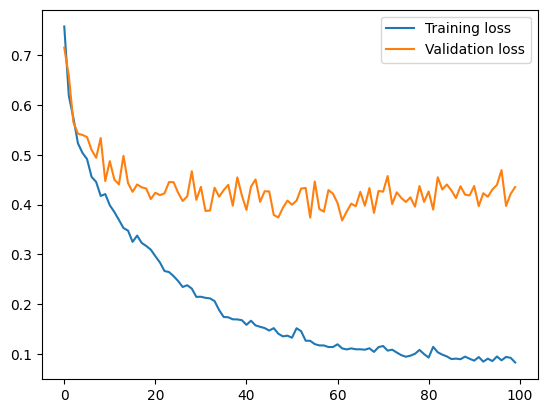

In [66]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [67]:
y_pred = model.predict(X_test)

y_pred_original = np.zeros((y_pred.shape[0], df_for_training.shape[1])) # Dummy array with correct number of columns
y_pred_original[:, -1] = y_pred[:, 0]  # Place predictions in the last column
y_pred_original = scaler.inverse_transform(y_pred_original)[:, -1]

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step


In [68]:
# Create a dummy array for y_test as well
y_test_original = np.zeros((y_test.shape[0], df_for_training.shape[1]))
y_test_original[:, -1] = y_test[:, 0]
y_test_original = scaler.inverse_transform(y_test_original)[:, -1]

In [69]:
print(y_pred_original)
print(y_test_original)

[114.51327153  78.03024548  50.28600911 ...  50.5428999   73.13041994
 169.30049198]
[ 84.  77.  59. ... 195.  53. 207.]


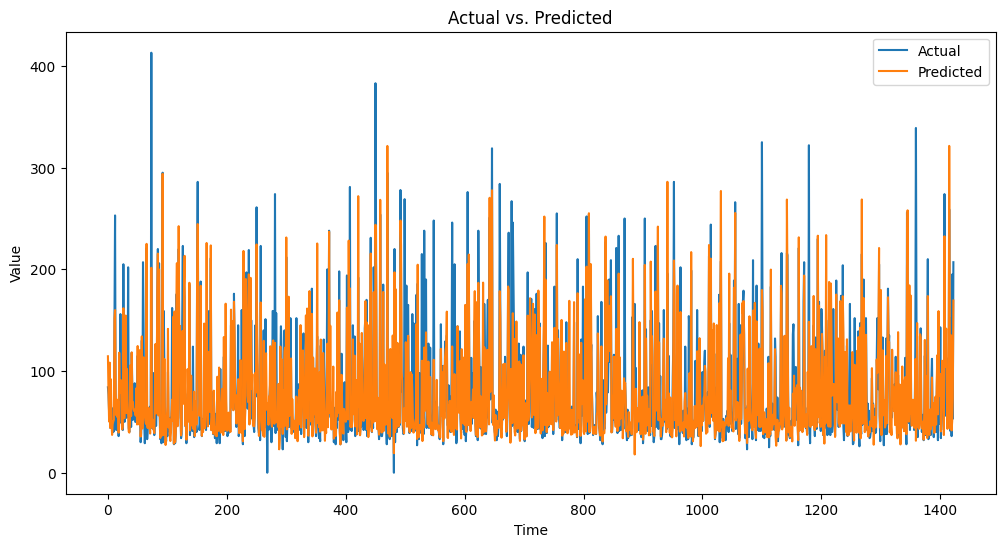

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [71]:
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1106.2828692598039


In [72]:
from sklearn.metrics import r2_score

# Calculate R² for the training set
y_train_pred = model.predict(X_train)

y_train_pred_original = np.zeros((y_train_pred.shape[0], df_for_training.shape[1]))
y_train_pred_original[:, -1] = y_train_pred[:, 0]
y_train_pred_original = scaler.inverse_transform(y_train_pred_original)[:, -1]

y_train_original = np.zeros((y_train.shape[0], df_for_training.shape[1]))
y_train_original[:, -1] = y_train[:, 0]
y_train_original = scaler.inverse_transform(y_train_original)[:, -1]

r2_train = r2_score(y_train_original, y_train_pred_original)
print(f'R² score for training set: {r2_train}')

# Calculate R² for the test set
y_test_pred = model.predict(X_test)

y_test_pred_original = np.zeros((y_test_pred.shape[0], df_for_training.shape[1]))
y_test_pred_original[:, -1] = y_test_pred[:, 0]
y_test_pred_original = scaler.inverse_transform(y_test_pred_original)[:, -1]

y_test_original = np.zeros((y_test.shape[0], df_for_training.shape[1]))
y_test_original[:, -1] = y_test[:, 0]
y_test_original = scaler.inverse_transform(y_test_original)[:, -1]

r2_test = r2_score(y_test_original, y_test_pred_original)
print(f'R² score for test set: {r2_test}')

178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
R² score for training set: 0.9144562142519573
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
R² score for test set: 0.6588349483804624
